In [ ]:
!unzip -q archive.zip

In [ ]:
!pip install --upgrade "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" --quiet
!pip install --upgrade --no-deps trl peft accelerate bitsandbytes transformers --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 61.3 MB/s eta 0:00:00


In [ ]:
from unsloth import FastLanguageModel
from datasets import Dataset, Image
from trl import SFTTrainer
from transformers import TrainingArguments
import torch
import pandas as pd
import json


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# 1. LOAD THE VISION MODEL
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/gemma-3-4b-it",
    max_seq_length=2048,
    load_in_4bit=True,
)

# 2. LOAD YOUR STRUCTURED DATASETS
# Define base path
base_path = "Doctor’s Handwritten Prescription BD dataset/"

# --- Load Training Data ---
train_df = pd.read_csv(f"{base_path}/Training/training_labels.csv")
# Create the full image path
train_df['file_path'] = train_df['IMAGE'].apply(lambda x: f"{base_path}/Training/training_words/{x}")
# Create Hugging Face Dataset and load images
train_dataset = Dataset.from_pandas(train_df).cast_column("file_path", Image())

# --- Load Validation Data ---
val_df = pd.read_csv(f"{base_path}/Validation/validation_labels.csv")
val_df['file_path'] = val_df['IMAGE'].apply(lambda x: f"{base_path}/Validation/validation_words/{x}")
val_dataset = Dataset.from_pandas(val_df).cast_column("file_path", Image())

print("Training and validation datasets loaded successfully!")


==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.55.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/4.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

Training and validation datasets loaded successfully!


In [ ]:
# 3. PREPARE THE DATA FOR STRUCTURED EXTRACTION
instruction = "You are an expert at reading medical prescriptions. Extract the medicine name and generic name from the image and provide the output in a structured JSON format."

def formatting_prompts_func(examples):
    # The 'file_path' column now contains the loaded images
    images = examples["file_path"]
    medicine_names = examples["MEDICINE_NAME"]
    generic_names = examples["GENERIC_NAME"]

    formatted_texts = []
    for i in range(len(images)):
        assistant_response = json.dumps({
            "medicine_name": medicine_names[i],
            "generic_name": generic_names[i]
        })
        chat = [
            {"role": "user", "content": f"{instruction}\n<image>"},
            {"role": "assistant", "content": assistant_response}
        ]
        formatted_texts.append(tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=False))

    # Return the images and the new formatted text prompt
    return { "image": images, "text": formatted_texts, }

train_dataset = train_dataset.map(formatting_prompts_func, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(formatting_prompts_func, batched=True, remove_columns=val_dataset.column_names)


Map:   0%|          | 0/3120 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import json
import re
from transformers import AutoTokenizer

# Use a separate tokenizer for evaluation
eval_tokenizer = AutoTokenizer.from_pretrained("unsloth/gemma-3-4b-it")

# ADDED: Ensure a pad token is set. The EOS token is a common choice.
if eval_tokenizer.pad_token_id is None:
    eval_tokenizer.pad_token_id = eval_tokenizer.eos_token_id

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # ADDED: Safety check to filter out invalid token IDs before decoding.
    # This clamps all predicted token IDs to the valid vocabulary range.
    vocab_size = eval_tokenizer.vocab_size
    predictions = np.clip(predictions, 0, vocab_size - 1)

    # Decode generated tokens to text
    decoded_preds = eval_tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, eval_tokenizer.pad_token_id)
    decoded_labels = eval_tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Clean up the decoded text to extract only the JSON part
    pred_jsons = []
    label_jsons = []

    for pred, label in zip(decoded_preds, decoded_labels):
        pred_assistant_part = pred.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
        label_assistant_part = label.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()

        pred_match = re.search(r'\{.*\}', pred_assistant_part, re.DOTALL)
        label_match = re.search(r'\{.*\}', label_assistant_part, re.DOTALL)

        try:
            pred_jsons.append(json.loads(pred_match.group(0)) if pred_match else {})
            label_jsons.append(json.loads(label_match.group(0)) if label_match else {})
        except (json.JSONDecodeError, AttributeError):
            pred_jsons.append({})
            label_jsons.append({})

    # Calculate Exact Match
    exact_matches = sum(1 for p, l in zip(pred_jsons, label_jsons) if p == l and l != {})
    em_score = exact_matches / len(label_jsons) if len(label_jsons) > 0 else 0

    # Calculate F1 score
    f1_scores = []
    for p, l in zip(pred_jsons, label_jsons):
        true_set = set(l.items())
        pred_set = set(p.items())

        tp = len(true_set.intersection(pred_set))
        fp = len(pred_set.difference(true_set))
        fn = len(true_set.difference(pred_set))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

    avg_f1 = np.mean(f1_scores)

    return {"exact_match": em_score, "f1_score": avg_f1}

In [ ]:
from trl import SFTTrainer
from typing import Optional, Tuple, Union, List, Dict, Any
import torch

class SFTTrainerWithGeneration(SFTTrainer):
    def prediction_step(
        self,
        model: torch.nn.Module,
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Optional[torch.Tensor]]:

        # Extract the labels before they are processed by the model
        labels = inputs.get("labels")

        # Use the model's generate function to get the predictions
        # This is the core of the workaround
        with torch.no_grad():
            generated_tokens = model.generate(
                input_ids=inputs.get("input_ids"),
                attention_mask=inputs.get("attention_mask"),
                pixel_values=inputs.get("pixel_values"),
                max_new_tokens=128,  # Adjust as needed
                do_sample=False,     # Use greedy decoding for consistent evaluation
            )

        # The trainer expects a tuple of (loss, predictions, labels)
        # We don't calculate loss here, so we return None for it.
        # The generated_tokens are our predictions.
        return (None, generated_tokens, labels)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model, r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16, lora_dropout=0, bias="none",
    use_gradient_checkpointing=True, random_state=3407,
)

trainer = SFTTrainerWithGeneration(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    max_seq_length=2048,
    compute_metrics=compute_metrics,
    args=TrainingArguments(
        output_dir="outputs",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        max_steps=100,
        learning_rate=2e-4,
        logging_steps=5,
        eval_strategy="steps",
        eval_steps=20,
        save_strategy="steps",
        save_steps=20,
        optim="adamw_8bit",
        seed=3407,
    ),
)


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Unsloth: Making `base_model.model.base_model.model.model.vision_tower.vision_model` require gradients
Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"]:   0%|          | 0/3120 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/780 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

print("Fine-tuning complete!")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,120 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 32,788,480 of 4,332,867,952 (0.76% trained)


Step,Training Loss,Validation Loss,Exact Match,F1 Score
20,0.465700,No log,1.000000,1.000000
40,0.190900,No log,1.000000,1.000000
60,0.131100,No log,1.000000,1.000000
80,0.118000,No log,0.987179,0.987179
100,0.100100,No log,1.000000,1.000000


Fine-tuning complete!


In [ ]:
model.save_pretrained("gemma3_prescription_extractor_fm")
tokenizer.save_pretrained("gemma3_prescription_extractor_fm")

print("Final model saved to 'gemma3_prescription_extractor_fm'")

Final model saved to 'gemma3_prescription_extractor_fm'


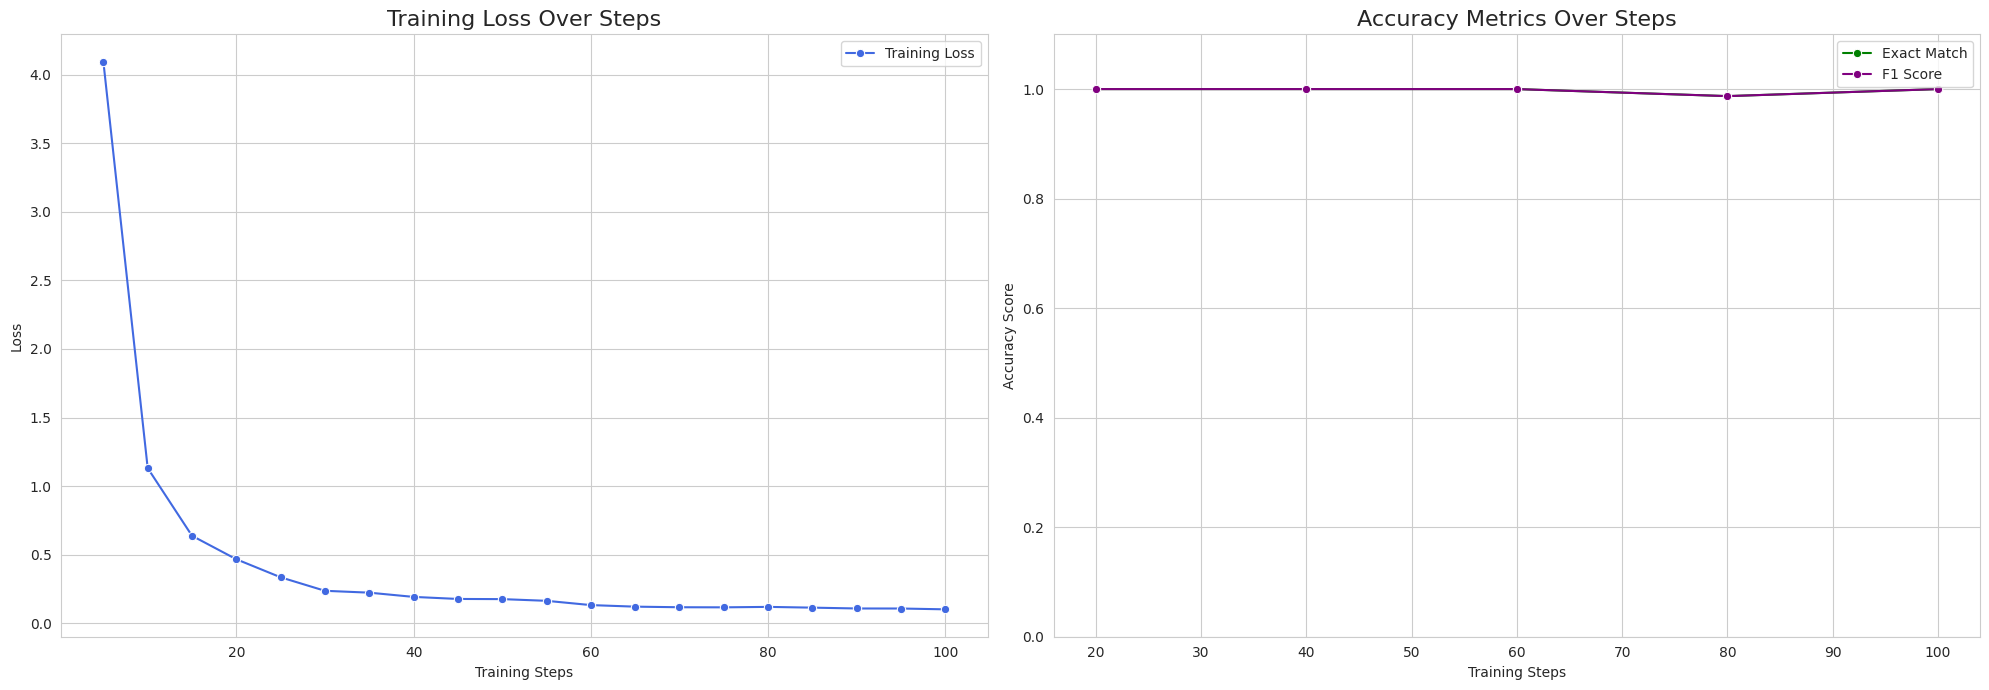

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Access the training log history
log_history = trainer.state.log_history

# Convert the log history to a pandas DataFrame
df = pd.DataFrame(log_history)

# Separate training and evaluation logs
train_logs = df[df['loss'].notna()].copy()
# CHANGED: We now filter for any evaluation metric, like 'eval_exact_match'
eval_logs = df[df['eval_exact_match'].notna()].copy()

# Rename columns for clarity in plots
train_logs.rename(columns={'loss': 'Training Loss'}, inplace=True)
eval_logs.rename(columns={'eval_exact_match': 'Exact Match',
                          'eval_f1_score': 'F1 Score'}, inplace=True)

# Set the style for the plots
sns.set_style("whitegrid")

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# --- Plot 1: Training Loss ---
# CHANGED: This plot now only shows the Training Loss
sns.lineplot(data=train_logs, x='step', y='Training Loss', ax=ax1, label='Training Loss', marker='o', color='royalblue')
ax1.set_title('Training Loss Over Steps', fontsize=16)
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.legend()

# --- Plot 2: Accuracy Metrics (This part is the same) ---
sns.lineplot(data=eval_logs, x='step', y='Exact Match', ax=ax2, label='Exact Match', marker='o', color='green')
sns.lineplot(data=eval_logs, x='step', y='F1 Score', ax=ax2, label='F1 Score', marker='o', color='purple')
ax2.set_title('Accuracy Metrics Over Steps', fontsize=16)
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Accuracy Score')
ax2.set_ylim(0, 1.1)
ax2.legend()

plt.tight_layout()
plt.savefig("model_performance_charts.png")
plt.show()